In [1]:
import pandas as pd
from datetime import datetime, date, timedelta
from requests import post
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(1, '../src/')
from basebot import BaseBot

In [3]:
bot = BaseBot("testbot")

df = bot.getData(ticker = "IWDA.AS", start_date = datetime(2010,1,1), technical_indicators=["all"])
df = bot.getTrend(df)
df.head()

,ticker,open,high,low,close,volume,adj_close,volume_adi,volume_obv,volume_cmf,...,momentum_kama,others_dr,others_dlr,others_cr,SMA_3,SMA_10,SMA_50,SMA_100,SMA_200,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-12,IWDA.AS,42.455002,42.674999,42.455002,42.575001,53831,42.575001,4893.896985,53831.0,0.090912,...,42.575001,-25.658017,0.433580,0.434522,42.725,42.7965,44.072,0,45.01955,1.0
2017-09-13,IWDA.AS,42.540001,42.759998,42.445000,42.759998,73915,42.759998,78808.896985,127746.0,0.616919,...,42.649766,0.434522,0.433580,0.434522,42.725,42.7965,44.072,0,45.01955,1.0
2017-09-14,IWDA.AS,42.730000,42.860001,42.689999,42.840000,19521,42.840000,93736.668981,147267.0,0.636508,...,42.724116,0.187095,0.186920,0.622430,42.725,42.7965,44.072,0,45.01955,1.0
2017-09-15,IWDA.AS,42.674999,42.689999,42.470001,42.575001,25357,42.575001,92584.257942,121910.0,0.536335,...,42.662290,-0.618579,-0.620500,0.364061,42.725,42.7965,44.072,0,45.01955,1.0
2017-09-18,IWDA.AS,42.779999,42.860001,42.669998,42.730000,44301,42.730000,76263.117764,166211.0,0.351564,...,42.689158,0.364061,0.363399,0.364061,42.715,42.7965,44.072,0,45.01955,1.0


In [4]:
df["signal"].value_counts()

 1.0    862
-1.0    435
Name: signal, dtype: int64

-1 represents sell (downtrend), 1 buy (uptrend), 0 is not yet decided

## simulate best possible scenario

(following signal)

<AxesSubplot:xlabel='timestamp'>

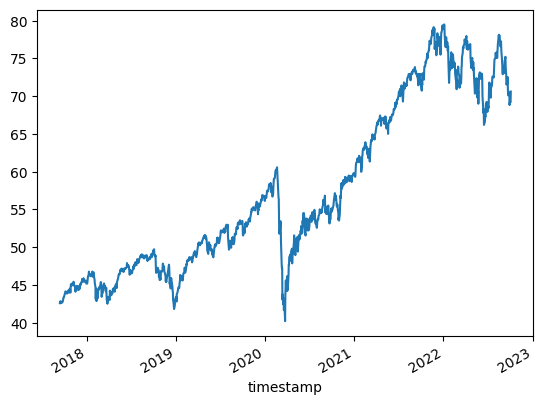

In [5]:
df["adj_close"].plot()

In [6]:
## calculate timespan
days = (df.index[-1] - df.index[0]).days
print("index takes %d days" % days)

index takes 1848 days


In [7]:
## baseline
startMoney = 10000
COMMISSION = 0.00025
nrStocks = startMoney / df.iloc[0]["adj_close"]
print("you would have bought {} stocks".format(nrStocks))
baselineWin = df.iloc[-1]["adj_close"] * nrStocks - startMoney
print("just holding would have given you %.2f$" % baselineWin)
baselineWinPerMonth = baselineWin / days * 30
print("or %.2f$ per month" % baselineWinPerMonth)

you would have bought 234.87961998358358 stocks
just holding would have given you 6582.50$
or 106.86$ per month


following the signal would have given you 24914.74$
or 404.46$ per month


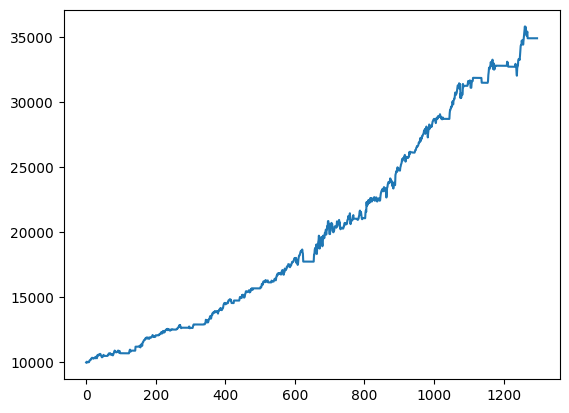

In [8]:
## next check if we follow signal what the best scenario would have been
money = startMoney
nrStocks = 0
bestPortfolio = []
for i in range(len(df)):
    if df.iloc[i]["signal"] == 1 and money > 0 and nrStocks == 0:
        amount = money / df.iloc[i]["adj_close"] * .99
        cost = amount * df.iloc[i]["adj_close"] * (1 + COMMISSION)
        money -= cost
        nrStocks += amount
    elif df.iloc[i]["signal"] == -1 and nrStocks > 0:
        money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
        nrStocks = 0
    bestPortfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
# last day sell nrStocks
money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
nrStocks = 0

win = money - startMoney
print("following the signal would have given you %.2f$" % win)
winPerMonth = win / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestPortfolio)

## find correlations

In [9]:
df.corr()["signal"]

open      -0.012703
high      -0.017628
low       -0.002791
close     -0.007943
volume    -0.189934
             ...   
SMA_10    -0.050470
SMA_50    -0.134352
SMA_100         NaN
SMA_200   -0.155830
signal     1.000000
Name: signal, Length: 98, dtype: float64

In [10]:
## try to get some observations with decision tree
from sklearn import tree
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(  df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0), df["signal"], test_size=0.2)
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
scr = clf.score(x_test, y_test)
print("decision tree scores: ", scr)
pred = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))
# tree.plot_tree(clf)

decision tree scores:  0.8384615384615385


In [11]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=x_train.columns,  
                        class_names=["sell", "buy"],
                        filled=True, rounded=True,
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
# graph 

## simulate one run with training data

the decision tree with lookback 0 would have given you 19817.72$
or +39.14% per year
or 321.72$ per month


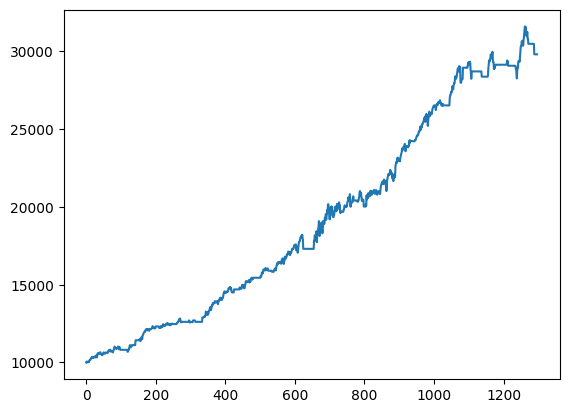

In [12]:



bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in [0]: # range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        # prednow = np.median(pred[i-lookback:i])
        prednow = pred[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the decision tree with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
# lookback of 1
# the decision tree would have given you 19937.82$
# or 323.67$ per month

## try the same with xgb

In [13]:
# xgb doesnt like -1
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

In [14]:
import xgboost as xgb
from sklearn import metrics


clf = xgb.XGBClassifier(n_jobs = -1)
clf.fit(x_train, y_train)
# print(clf)
predicted_y = clf.predict(x_test)


In [15]:
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))



              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86        91
         1.0       0.92      0.93      0.92       169

    accuracy                           0.90       260
   macro avg       0.89      0.89      0.89       260
weighted avg       0.90      0.90      0.90       260

[[ 77  14]
 [ 12 157]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

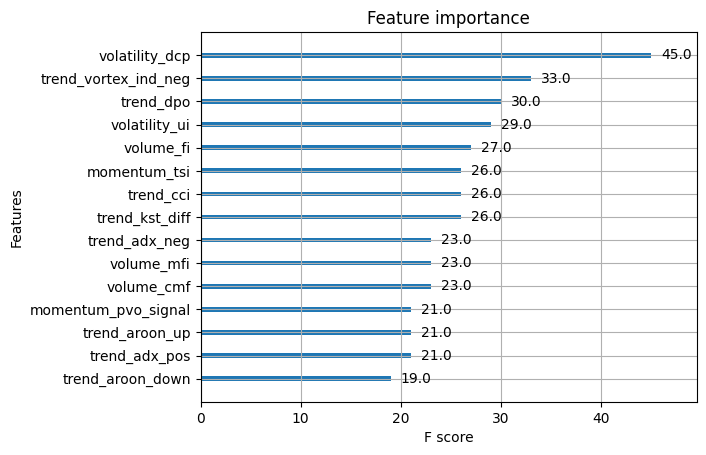

In [16]:
xgb.plot_importance(clf, max_num_features=15)

In [17]:
preds = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))

/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the XGB with lookback 3 would have given you 6510.10$
or +12.86% per year
or 105.68$ per month


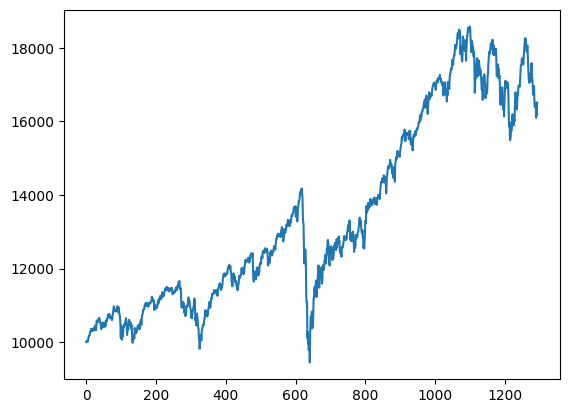

In [18]:
## do the same dance as with tree


bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        prednow = np.median(preds[i-lookback:i])
        # prednow = preds[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the XGB with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the XGB with lookback 3 would have given you 6510.10$
# or +12.86% per year
# or 105.68$ per month


## lgbm classifer

In [19]:
import lightgbm as ltb
clf = ltb.LGBMClassifier()
clf.fit(x_train, y_train)
predicted_y = clf.predict(x_test)
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84        91
         1.0       0.90      0.94      0.92       169

    accuracy                           0.89       260
   macro avg       0.89      0.87      0.88       260
weighted avg       0.89      0.89      0.89       260

[[ 73  18]
 [ 10 159]]


In [20]:
preds = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))

/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the lightgbm with lookback 3 would have given you 6510.10$
or +12.86% per year
or 105.68$ per month


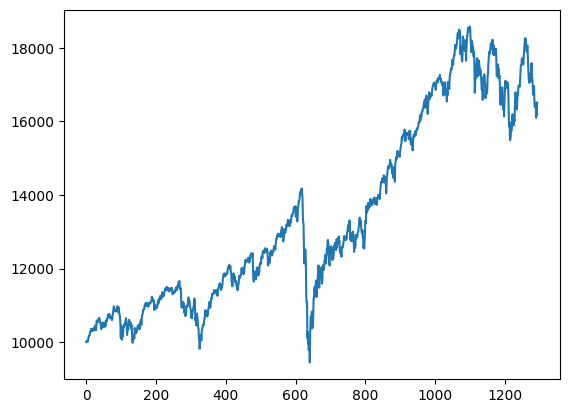

In [21]:
## do the same dance as with xgb


bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        prednow = np.median(preds[i-lookback:i])
        # prednow = preds[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the lightgbm with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the xgb with lookback 3 would have given you 3497.44$
# or +6.91% per year
# or 56.78$ per month
## lightgbm 
# the lightgbm with lookback 3 would have given you 6510.10$
# or +12.86% per year
# or 105.68$ per month

## linear SVC with pipeline

In [22]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(),LinearSVC())

clf.fit(x_train, y_train)

predicted_y = clf.predict(x_test)
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84        91
         1.0       0.91      0.93      0.92       169

    accuracy                           0.89       260
   macro avg       0.88      0.88      0.88       260
weighted avg       0.89      0.89      0.89       260

[[ 75  16]
 [ 12 157]]


/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {'SVC__C':np.arange(0.01,100,10)}

SVCpipe = Pipeline([('scale', StandardScaler()),
                ('SVC',LinearSVC())])
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=4,return_train_score=True,n_jobs = -1)
linearSVC.fit(x_train,y_train)
print(linearSVC.best_params_)
bestlinearSVC = linearSVC.best_estimator_

predicted_y = bestlinearSVC.predict(x_test)
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))

/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: Convergenc

{'SVC__C': 0.01}
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87        91
         1.0       0.93      0.93      0.93       169

    accuracy                           0.91       260
   macro avg       0.90      0.90      0.90       260
weighted avg       0.91      0.91      0.91       260

[[ 79  12]
 [ 11 158]]


# now something interesting, what if we use the same for another stock :o?

In [24]:
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [25]:
df = bot.getData(ticker = "AAPL", start_date = datetime(2010,1,1), technical_indicators=["all"])
df = bot.getTrend(df)

preds = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))
print(metrics.classification_report(df["signal"], preds))
print(metrics.confusion_matrix(df["signal"], preds))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       454
         0.0       0.00      0.00      0.00         0
         1.0       0.82      0.82      0.82       822

    accuracy                           0.53      1276
   macro avg       0.27      0.27      0.27      1276
weighted avg       0.53      0.53      0.53      1276

[[  0 307 147]
 [  0   0   0]
 [  0 148 674]]


/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jguese/miniconda3/lib/pytho

if we use it for another stock performance is not too good!
but well that shouldn't surprise us.

next try to train on a ton of different data and see if we can create a generalized predictor

In [26]:
bigDf = []
for ticker in ["CWEG.L", "IWDA.AS", "EEM", "AAPL", "MSFT", "GOOG", "TSLA", 'AMD', 'AMZN', 'DG', "ETH-USD"]:
    print("geddin stock: " + ticker)
    df = bot.getData(ticker = ticker, start_date = datetime(2010,1,1), technical_indicators=["all"])
    df = bot.getTrend(df)
    bigDf.append(df)
    
bigDf = pd.concat(bigDf)
bigDf.head()

geddin stock: CWEG.L
geddin stock: IWDA.AS
geddin stock: EEM
geddin stock: AAPL
geddin stock: MSFT
geddin stock: GOOG
geddin stock: TSLA
geddin stock: AMD
geddin stock: AMZN
geddin stock: DG
geddin stock: ETH-USD


,ticker,open,high,low,close,volume,adj_close,volume_adi,volume_obv,volume_cmf,...,momentum_kama,others_dr,others_dlr,others_cr,SMA_3,SMA_10,SMA_50,SMA_100,SMA_200,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-09,CWEG.L,22440.0,22440.0,22430.0,22470.0,1400,22470.0,9800.0,1400.0,7.000000,...,22470.000000,-4.433549,-0.591421,-0.589675,22313.333333,25491.75,21117.01,0,0.0,1.0
2018-03-21,CWEG.L,21870.0,21870.0,21870.0,22337.5,1400,22337.5,9800.0,-34.0,3.500000,...,22409.540207,-0.589675,-0.591421,-0.589675,23607.500000,25041.25,21117.01,0,0.0,1.0
2018-03-27,CWEG.L,22090.0,22090.0,22090.0,22132.5,34,22132.5,9800.0,-34.0,3.458010,...,22281.687834,-0.917739,-0.921976,-1.502003,22313.333333,25491.75,21117.01,0,0.0,1.0
2018-05-15,CWEG.L,26400.0,26400.0,26400.0,26352.5,619,26352.5,9800.0,585.0,2.838112,...,22828.240240,19.066983,17.451603,17.278594,23607.500000,25041.25,21117.01,0,0.0,1.0
2018-05-29,CWEG.L,25345.0,25345.0,25345.0,25532.5,619,25532.5,9800.0,-34.0,2.406680,...,23200.201165,-3.111659,-3.161100,13.629283,24672.500000,25491.75,21117.01,0,0.0,1.0


In [27]:
x_train, x_test, y_train, y_test = train_test_split(  df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0), df["signal"], test_size=0.1, shuffle=True)
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
scr = clf.score(x_test, y_test)
print("decision tree scores: ", scr)
pred = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))

decision tree scores:  0.8888888888888888


In [28]:
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=x_train.columns,  
                        class_names=["sell", "buy"],
                        filled=True, rounded=True,
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
# graph

In [29]:
## simulate


bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = dict()
for lookback in range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = dict()
    for i in range(lookback, len(df)):
        prednow = np.median(preds[i-lookback:i])
        # if we switched stock sell the old and continue with new
        if df.iloc[i]["ticker"] != df.iloc[i-1]["ticker"]:
            money += nrStocks * df.iloc[i-1]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
            portfolio[df.iloc[i]["ticker"]] = []
        # prednow = preds[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        try:
            portfolio[df.iloc[i]["ticker"]] = portfolio[df.iloc[i]["ticker"]].append(money + nrStocks * df.iloc[i]["adj_close"])
        except:
            # idk
            pass
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the lightgbm with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
days = (df.index[-1] - df.index[0]).days
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
for ticker,portfolio in bestLookbackPortfolio:
    plt.title(ticker)
    plt.plot(bestLookbackPortfolio)
    plt.show()
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the xgb with lookback 3 would have given you 3497.44$
# or +6.91% per year
# or 56.78$ per month
## lightgbm 
# the lightgbm with lookback 3 would have given you 6510.10$
# or +12.86% per year
# or 105.68$ per month

/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the lightgbm with lookback 2 would have given you 33888.89$
or +69.10% per year
or 567.97$ per month


## next try to "dumb" down decision tree until we find a good mix between reducing accuracy and complexity



In [30]:
## limit to one stock?
df = bot.getData(ticker = "IWDA.AS", start_date = datetime(2010,1,1), technical_indicators=["all"])
df = bot.getTrend(df)

In [36]:
# for this use the whole data
X, Y = df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0), df["signal"]


In [52]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def getDecision(dfrow):")

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if dfrow['{}'] <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if dfrow['{}'] > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node][0])))

    recurse(0, 1)
# tree_to_code(clf, x_train.columns)

In [38]:
def getDecision(dfrow):
    if dfrow['momentum_rsi'] <= 49.91:
        if dfrow['trend_aroon_ind'] <= -22.0:
            return 0
        else:  # if dfrow['trend_aroon_ind'] > -22.0
            if dfrow['trend_kst_diff'] <= 5.96:
                if dfrow['volatility_bbw'] <= 11.39:
                    return 0
                else:  # if dfrow['volatility_bbw'] > 11.39
                    return 1
            else:  # if dfrow['trend_kst_diff'] > 5.96
                return 1
    else:  # if dfrow['momentum_rsi'] > 49.91
        if dfrow['trend_aroon_ind'] <= -34.0:
            if dfrow['trend_aroon_up'] <= 10.0:
                return 1
            else:  # if dfrow['trend_aroon_up'] > 10.0
                return 0
        else:  # if dfrow['trend_aroon_ind'] > -34.0
            if dfrow['trend_adx_pos'] <= 19.34:
                return 0
            else:  # if dfrow['trend_adx_pos'] > 19.34
                return 1

In [63]:
def oneRun(model, lookbackarray = [1]):
    preds = model.predict(X)
    # print("the predictions are: ", np.unique(preds, return_counts=True))
    bestLookback = -1
    bestLookbackWin = -9999
    bestLookbackPortfolio = []
    for lookback in lookbackarray: # range(0, 5):
        money = startMoney
        nrStocks = 0
        portfolio = []
        for i in range(lookback, len(df)):
            # prednow = np.median(preds[i-lookback:i])
            prednow = preds[i]
            # "translate" 0 to -1 like we did it before
            if prednow == 0:
                prednow = -1
            # print("prednow is, " , prednow)
            # prednow = preds[i]
            if prednow == 1 and nrStocks == 0 and money > 10:
                # buy
                howmany = money / df.iloc[i]["adj_close"] * .99
                cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
                money -= cost
                nrStocks += howmany
            elif prednow == -1 and nrStocks > 0:
                money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
                nrStocks = 0
            portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
        # last day sell
        money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
        win = money - startMoney
        if win > bestLookbackWin:
            bestLookback = lookback
            bestLookbackWin = win
            bestLookbackPortfolio = portfolio
    return bestLookbackWin, bestLookback, bestLookbackPortfolio
## try it with a "blank" model
clf = tree.DecisionTreeClassifier()
clf.fit(X, Y)
scr = clf.score(X, Y)
print("score is: ", scr)
bestLookbackWin, bestLookback, bestLookbackPortfolio = oneRun(clf, lookbackarray = [1,3,5,10])
print("the un-tuned getDecision decision tree with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
days = (df.index[-1] - df.index[0]).days
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
# plt.plot(bestLookbackPortfolio)

# just holding would have given you 6582.50$
# or 106.86$ per month

score is:  1.0
the un-tuned getDecision decision tree with lookback 3 would have given you 24914.74$
or +49.21% per year
or 404.46$ per month


### reduce depth

In [106]:
from tqdm import tqdm
justHoldingWin = 6582

bestDepth = -1
bestLeafes = -1
bestLookback = -1
bestDepthWin = -9999
collection = []
# explicitly force a max of 20 to prevent overfitting
for depth in tqdm([50,40,30,20,15,10,7,5,3]):
    for leafes in [50,40,30,20,15,10,7,5,3]:
        clf = tree.DecisionTreeClassifier(max_depth=depth, max_leaf_nodes = leafes)
        clf.fit(X, Y)
        # scr = clf.score(X, Y)
        # print("score is: ", scr)
        bestLookbackWin, lookback, bestLookbackPortfolio = oneRun(clf)
        collection.append([depth,leafes,lookback,bestLookbackWin])
        if bestLookbackWin >= (bestDepthWin*.95): # equal to prefer smaller trees, 95% to accept a bit worse for smaller trees
            bestDepthWin = bestLookbackWin
            bestDepth = depth
            bestLeafes = leafes
            bestLookback = lookback
print("the best depth is %d, best leave %d, best lookback %d. with a win of %.2f$" % (bestDepth, bestLeafes, bestLookback, bestDepthWin))

100%|██████████| 9/9 [00:13<00:00,  1.47s/it]

the best depth is 10, best leave 50, best lookback 1. with a win of 19606.17$


In [107]:
collection = pd.DataFrame(collection, columns = ["depth", "leafes", "lookback", "win"])
collection.sort_values(by="win", ascending=False, inplace=True)
collection.head(20)

,depth,leafes,lookback,win
45,10,50,1,19606.173826
18,30,50,1,19606.173826
36,15,50,1,19606.173826
0,50,50,1,19421.064143
27,20,50,1,19421.064143
9,40,50,1,19344.588217
1,50,40,1,18488.345168
10,40,40,1,18488.345168
46,10,40,1,18377.996473
37,15,40,1,18377.996473


              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98       435
         1.0       0.99      0.99      0.99       862

    accuracy                           0.99      1297
   macro avg       0.99      0.99      0.99      1297
weighted avg       0.99      0.99      0.99      1297

[[429   6]
 [  8 854]]
the hyperoptimized getDecision decision tree with lookback 1 would have given you 19460.34$
or +38.44% per year
or 315.91$ per month


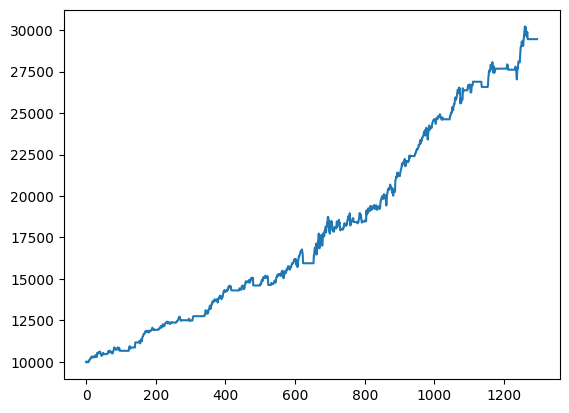

In [108]:
clf = tree.DecisionTreeClassifier(max_depth=bestDepth, max_leaf_nodes = bestLeafes)
clf.fit(X, Y)
preds = clf.predict(X)
print(metrics.classification_report(df["signal"], preds))
print(metrics.confusion_matrix(df["signal"], preds))
bestLookbackWin, bestLookback, bestLookbackPortfolio = oneRun(clf, lookbackarray = [bestLookback])
print("the hyperoptimized getDecision decision tree with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
days = (df.index[-1] - df.index[0]).days
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)

the hyperoptimized getDecision decision tree with lookback 1 would have given you 11846.45$

or +23.40% per year

or 192.31$ per month

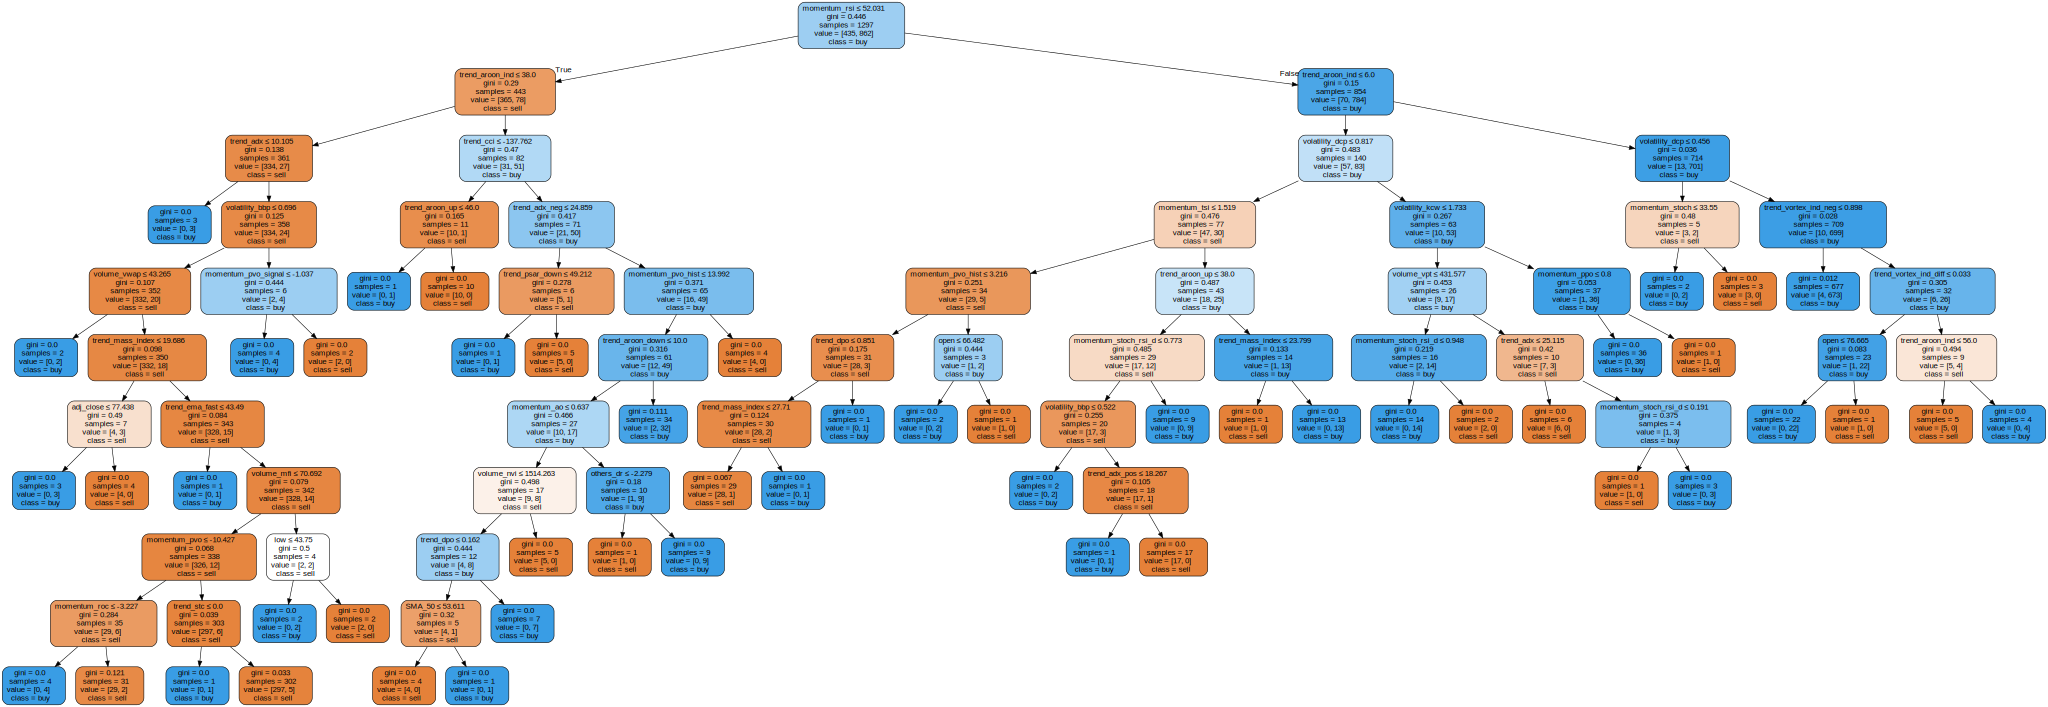

In [109]:
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=x_train.columns,  
                        class_names=["sell", "buy"],
                        filled=True, rounded=True,
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

In [110]:
tree_to_code(clf, x_train.columns)

def getDecision(dfrow):
    if dfrow['momentum_rsi'] <= 52.03:
        if dfrow['trend_aroon_ind'] <= 38.0:
            if dfrow['trend_adx'] <= 10.1:
                return 1
            else:  # if dfrow['trend_adx'] > 10.1
                if dfrow['volatility_bbp'] <= 0.7:
                    if dfrow['volume_vwap'] <= 43.27:
                        return 1
                    else:  # if dfrow['volume_vwap'] > 43.27
                        if dfrow['trend_mass_index'] <= 19.69:
                            if dfrow['adj_close'] <= 77.44:
                                return 1
                            else:  # if dfrow['adj_close'] > 77.44
                                return 0
                        else:  # if dfrow['trend_mass_index'] > 19.69
                            if dfrow['trend_ema_fast'] <= 43.49:
                                return 1
                            else:  # if dfrow['trend_ema_fast'] > 43.49
                                if dfrow['volume_mfi'] 

In [113]:
def getDecision(dfrow):
    if dfrow['momentum_rsi'] <= 52.03:
        if dfrow['trend_aroon_ind'] <= 38.0:
            if dfrow['trend_adx'] <= 10.1:
                return 1
            else:  # if dfrow['trend_adx'] > 10.1
                if dfrow['volatility_bbp'] <= 0.7:
                    if dfrow['volume_vwap'] <= 43.27:
                        return 1
                    else:  # if dfrow['volume_vwap'] > 43.27
                        if dfrow['trend_mass_index'] <= 19.69:
                            if dfrow['adj_close'] <= 77.44:
                                return 1
                            else:  # if dfrow['adj_close'] > 77.44
                                return 0
                        else:  # if dfrow['trend_mass_index'] > 19.69
                            if dfrow['trend_ema_fast'] <= 43.49:
                                return 1
                            else:  # if dfrow['trend_ema_fast'] > 43.49
                                if dfrow['volume_mfi'] <= 70.69:
                                    if dfrow['momentum_pvo'] <= -10.43:
                                        if dfrow['momentum_roc'] <= -3.23:
                                            return 1
                                        else:  # if dfrow['momentum_roc'] > -3.23
                                            return 0
                                    else:  # if dfrow['momentum_pvo'] > -10.43
                                        if dfrow['trend_stc'] <= 0.0:
                                            return 1
                                        else:  # if dfrow['trend_stc'] > 0.0
                                            return 0
                                else:  # if dfrow['volume_mfi'] > 70.69
                                    if dfrow['low'] <= 43.75:
                                        return 1
                                    else:  # if dfrow['low'] > 43.75
                                        return 0
                else:  # if dfrow['volatility_bbp'] > 0.7
                    if dfrow['momentum_pvo_signal'] <= -1.04:
                        return 1
                    else:  # if dfrow['momentum_pvo_signal'] > -1.04
                        return 0
        else:  # if dfrow['trend_aroon_ind'] > 38.0
            if dfrow['trend_cci'] <= -137.76:
                if dfrow['trend_aroon_up'] <= 46.0:
                    return 1
                else:  # if dfrow['trend_aroon_up'] > 46.0
                    return 0
            else:  # if dfrow['trend_cci'] > -137.76
                if dfrow['trend_adx_neg'] <= 24.86:
                    if dfrow['trend_psar_down'] <= 49.21:
                        return 1
                    else:  # if dfrow['trend_psar_down'] > 49.21
                        return 0
                else:  # if dfrow['trend_adx_neg'] > 24.86
                    if dfrow['momentum_pvo_hist'] <= 13.99:
                        if dfrow['trend_aroon_down'] <= 10.0:
                            if dfrow['momentum_ao'] <= 0.64:
                                if dfrow['volume_nvi'] <= 1514.26:
                                    if dfrow['trend_dpo'] <= 0.16:
                                        if dfrow['SMA_50'] <= 53.61:
                                            return 0
                                        else:  # if dfrow['SMA_50'] > 53.61
                                            return 1
                                    else:  # if dfrow['trend_dpo'] > 0.16
                                        return 1
                                else:  # if dfrow['volume_nvi'] > 1514.26
                                    return 0
                            else:  # if dfrow['momentum_ao'] > 0.64
                                if dfrow['others_dr'] <= -2.28:
                                    return 0
                                else:  # if dfrow['others_dr'] > -2.28
                                    return 1
                        else:  # if dfrow['trend_aroon_down'] > 10.0
                            return 1
                    else:  # if dfrow['momentum_pvo_hist'] > 13.99
                        return 0
    else:  # if dfrow['momentum_rsi'] > 52.03
        if dfrow['trend_aroon_ind'] <= 6.0:
            if dfrow['volatility_dcp'] <= 0.82:
                if dfrow['momentum_tsi'] <= 1.52:
                    if dfrow['momentum_pvo_hist'] <= 3.22:
                        if dfrow['trend_dpo'] <= 0.85:
                            if dfrow['trend_mass_index'] <= 27.71:
                                return 0
                            else:  # if dfrow['trend_mass_index'] > 27.71
                                return 1
                        else:  # if dfrow['trend_dpo'] > 0.85
                            return 1
                    else:  # if dfrow['momentum_pvo_hist'] > 3.22
                        if dfrow['open'] <= 66.48:
                            return 1
                        else:  # if dfrow['open'] > 66.48
                            return 0
                else:  # if dfrow['momentum_tsi'] > 1.52
                    if dfrow['trend_aroon_up'] <= 38.0:
                        if dfrow['momentum_stoch_rsi_d'] <= 0.77:
                            if dfrow['volatility_bbp'] <= 0.52:
                                return 1
                            else:  # if dfrow['volatility_bbp'] > 0.52
                                if dfrow['trend_adx_pos'] <= 18.27:
                                    return 1
                                else:  # if dfrow['trend_adx_pos'] > 18.27
                                    return 0
                        else:  # if dfrow['momentum_stoch_rsi_d'] > 0.77
                            return 1
                    else:  # if dfrow['trend_aroon_up'] > 38.0
                        if dfrow['trend_mass_index'] <= 23.8:
                            return 0
                        else:  # if dfrow['trend_mass_index'] > 23.8
                            return 1
            else:  # if dfrow['volatility_dcp'] > 0.82
                if dfrow['volatility_kcw'] <= 1.73:
                    if dfrow['volume_vpt'] <= 431.58:
                        if dfrow['momentum_stoch_rsi_d'] <= 0.95:
                            return 1
                        else:  # if dfrow['momentum_stoch_rsi_d'] > 0.95
                            return 0
                    else:  # if dfrow['volume_vpt'] > 431.58
                        if dfrow['trend_adx'] <= 25.11:
                            return 0
                        else:  # if dfrow['trend_adx'] > 25.11
                            if dfrow['momentum_stoch_rsi_d'] <= 0.19:
                                return 0
                            else:  # if dfrow['momentum_stoch_rsi_d'] > 0.19
                                return 1
                else:  # if dfrow['volatility_kcw'] > 1.73
                    if dfrow['momentum_ppo'] <= 0.8:
                        return 1
                    else:  # if dfrow['momentum_ppo'] > 0.8
                        return 0
        else:  # if dfrow['trend_aroon_ind'] > 6.0
            if dfrow['volatility_dcp'] <= 0.46:
                if dfrow['momentum_stoch'] <= 33.55:
                    return 1
                else:  # if dfrow['momentum_stoch'] > 33.55
                    return 0
            else:  # if dfrow['volatility_dcp'] > 0.46
                if dfrow['trend_vortex_ind_neg'] <= 0.9:
                    return 1
                else:  # if dfrow['trend_vortex_ind_neg'] > 0.9
                    if dfrow['trend_vortex_ind_diff'] <= 0.03:
                        if dfrow['open'] <= 76.67:
                            return 1
                        else:  # if dfrow['open'] > 76.67
                            return 0
                    else:  # if dfrow['trend_vortex_ind_diff'] > 0.03
                        if dfrow['trend_aroon_ind'] <= 56.0:
                            return 0
                        else:  # if dfrow['trend_aroon_ind'] > 56.0
                            return 1


In [112]:
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the xgb with lookback 3 would have given you 3497.44$
# or +6.91% per year
# or 56.78$ per month
## lightgbm 
# the lightgbm with lookback 3 would have given you 6510.10$
# or +12.86% per year
# or 105.68$ per month
## tuned decision tree
# the tuned getDecision decision tree with lookback 1 would have given you 39171.64$
# or +77.33% per year
# or 635.56$ per month
## just holding
# just holding would have given you 6582.50$
# or 106.86$ per month
## hyperopt tree
# the hyperoptimized getDecision decision tree with lookback 1 would have given you 19460.34$
# or +38.44% per year
# or 315.91$ per month